##Drive amount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Install libaries

In [ ]:
!pip install pyodbc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.8/329.8 KB 9.8 MB/s eta 0:00:00


In [ ]:
!pip install catboost


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 7.7 MB/s eta 0:00:00


In [ ]:
import pyodbc
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC # "Support vector classifier"  
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import pickle
from datetime import date
import csv
from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
import os
pd.set_option('display.max_columns', None)
from sklearn.ensemble import VotingClassifier


## Connect with SQL server

In [ ]:
report_driver = '{SQL Server}'
report_server = '172.21.105.125'
report_database = 'Pocket'
report_uid = 'python_user'
report_pwd = 'cnWVDSYVmci5nLyN'

In [ ]:
all_users = pd.DataFrame()
sales= pd.DataFrame()
campaigns= pd.DataFrame()
sales_campaigns= pd.DataFrame()

Users' information

In [ ]:
# all_users_query = """select u.[user account], trim(replace(u.[customer name],'"','')) as [customer name], u.[mobile phone],
# u.birthday,u.gender,u.city,u.[perx registration date],u.state,u.[email id]
# from [Newly Created User Report] as u"""

all_users_query="""select * from [dbo].[Newly Created User Report] where state='active'"""

In [ ]:
def db_connect_users():
    global all_users
    
    conn = pyodbc.connect(driver=report_driver,
                        server=report_server,
                        database=report_database,
                        uid=report_uid,
                        pwd=report_pwd,
                        autocomit=True)
    
    all_users = pd.read_sql(all_users_query,conn)    

    conn.close()

In [ ]:
db_connect_users()

Sales activity by users' information

In [ ]:
sales_query = """select uu.[user account],uu.[customer name],
cam.[merchant name],
sum(case when cam.[T type] in ('Sales','Manual') then cam.[points earned] else 0 end) as sales_point_earned,
sum(cam.[points burned]) as total_point_burned,
sum(case when cam.[T type]='Vouchers' and cam.[reward category]='Purchase reward' and cam.[voucher id]<>0 then 1 else 0 end) 
as sales_vouchers,
sum(case when cam.[T type]='Vouchers' and cam.[reward category]='Purchase reward' and cam.[last engagement status]='expired' and cam.[voucher id]<>0 then 1 else 0 end) 
as sales_expired_vouchers
from (
	select u.[user account], trim(replace(u.[customer name],'"','')) as [customer name], u.[mobile phone],
	u.birthday,u.gender,u.city,u.[perx registration date],u.state,u.[email id]
	from [Newly Created User Report] as u
) as uu
left join (
	select d.[user account id],d.[transaction date],d.[merchant name],d.[redeemed by merchant user name],
	d.[T type],d.[reward category],
	case when d.[campaign id]=0 and c.[campaign id] is not null then c.[campaign id] 
	when d.[campaign id]=0 then NULL else d.[campaign id] end as [campaign id],
	case when d.[campaign name] ='' and c.[campaign name] is not null then replace(c.[campaign name],'"','')
	else d.[campaign name] end as [campaign name],
	d.[transaction id],d.[points earned],d.[points burned],d.[voucher id],d.[reward id],d.[reward name],d.[last engagement status]
	from Daily_Transaction as d
	left join [Campaign Engagement - Breakdown] as c on c.[reward id]=d.[reward id]
) as cam on cam.[user account id] = uu.[user account]
group by uu.[user account],uu.[customer name],cam.[merchant name]
"""

In [ ]:
def db_connect_sales():
    global sales
    
    conn = pyodbc.connect(driver=report_driver,
                        server=report_server,
                        database=report_database,
                        uid=report_uid,
                        pwd=report_pwd,
                        autocomit=True)  
    sales=pd.read_sql(sales_query,conn)


    conn.close()

In [ ]:
db_connect_sales()

In [ ]:
sales.head()

,user account,customer name,merchant name,sales_point_earned,total_point_burned,sales_vouchers,sales_expired_vouchers
0,4011470395-1668751639,Ei MyatNoe Oo,KFC,182,0.0,0,0
1,36638763748-1674818457,HtooHtoo,Star City,0,0.0,0,0
2,25398997836-1671979058,ThiriYamin Su,Star City,0,0.0,0,0
3,31350661369-1672988426,AungThu,None,0,NaN,0,0
4,25445817058-1671981504,KyawTHU YA TUN,Star City,0,0.0,0,0


Campaigns' information

In [ ]:
campaign_query="""select * 
from (
    select trim(str(c.[campaign id])) as [campaign id],replace(c.[campaign name],'"','') as [campaign name] 
    from [Campaign Engagement - Breakdown] as c 
    union all
    select concat('R-',r.[rule id]) as [campaign id],r.[rule name]
    from [Rule Builder Report - Summary] as r
    where r.[rule id] in (200,305)
    group by r.[rule id],r.[rule name]
) as out 
group by out.[campaign id],out.[campaign name]"""
# campaign_query="""select top 10 * from [Campaign Engagement - Breakdown]"""

In [ ]:
def db_connect_campaigns():
    global campaigns
    
    conn = pyodbc.connect(driver=report_driver,
                        server=report_server,
                        database=report_database,
                        uid=report_uid,
                        pwd=report_pwd,
                        autocomit=True)
    
    campaigns=pd.read_sql(campaign_query,conn)
    

    conn.close()

In [ ]:
len(campaigns.drop_duplicates(subset='campaign id'))

0

In [ ]:
campaigns.head()

,campaign id,campaign name
0,1,Collect Stamps to get FREEBIES!
1,1,Collect Stamps to get FREEBIES!
2,1,Collect Stamps to get FREEBIES!
3,2,"Earn 1 Stamp for Every 10,000 Kyats you spent"
4,2,"Earn 1 Stamp for Every 10,000 Kyats you spent"


In [ ]:
db_connect_campaigns()

In [ ]:
combined_query="""select uu.[user account],uu.[customer name],uu.[mobile phone],cam.[merchant name],
case When cam.[rule id] is not null and cam.[rule id] <>0 then trim(concat('R-',cam.[rule id])) 
else trim(str(cam.[campaign id])) end as [campaign id],
case when cam.[rule id] is not null and cam.[rule id] <>0 then cam.[rule name]
else cam.[campaign name] end as [campaign name], 
sum(case when (cam.[rule id] is not null and cam.[rule id] <>0) 
or (cam.[campaign id] <>0 and cam.[campaign id] is not null) then 1 else 0 end) as participated_campaign_frequency,
sum(case when cam.[T type] = 'Campaigns' then cam.[points earned] else 0 end) as campaigns_point_earned,
sum(case when cam.[T type]='Vouchers' and cam.[reward category]='Campaign reward' and cam.[campaign name] like '%stamp%' and cam.[voucher id]<>0 then 1 else 0 end)
as stamp_vouchers,
sum(case when cam.[T type]='Vouchers' and cam.[reward category]='Campaign reward' and cam.[campaign name] like '%stamp%' and cam.[last engagement status]='expired' and cam.[voucher id]<>0 then 1 else 0 end) 
as stamp_expired_vouchers,
sum(case when cam.[T type]='Vouchers' and cam.[reward category]='Campaign reward' and cam.[campaign name] not like '%stamp%' and cam.[voucher id]<>0 then 1 else 0 end) 
as game_vouchers,
sum(case when cam.[T type]='Vouchers' and cam.[reward category]='Campaign reward' and cam.[campaign name] not like '%stamp%' and cam.[last engagement status]='expired' and cam.[voucher id]<>0 then 1 else 0 end) 
as game_expired_vouchers
from (
    select u.[user account], trim(replace(u.[customer name],'"','')) as [customer name], u.[mobile phone],
    u.birthday,u.gender,u.city,u.[perx registration date],u.state,u.[email id]
    from [Newly Created User Report] as u
) as uu
left join (
    select d.[user account id],d.[transaction date],d.[merchant name],d.[redeemed by merchant user name],
    d.[T type],d.[reward category],
    case when d.[campaign id]=0 and c.[campaign id] is not null then c.[campaign id]
       else d.[campaign id] end as [campaign id],
    case when d.[campaign name]='' and c.[campaign name] is not null then replace(c.[campaign name],'"','')
    else d.[campaign name] end as [campaign name],
    d.[transaction id],d.[points earned],d.[points burned],d.[voucher id],d.[reward id],d.[reward name],d.[last engagement status],
    d.[rule id],d.[rule name]
    from Daily_Transaction as d
    left join [Campaign Engagement - Breakdown] as c on c.[reward id]=d.[reward id]
    where (d.[rule id] in (200,305) or d.[T type] in ('Campaigns') or (d.[T type] in ('Vouchers') and d.[reward category]='Campaign reward'))
) as cam on cam.[user account id] = uu.[user account]
group by uu.[user account],uu.[customer name],cam.[campaign id],cam.[campaign name],cam.[merchant name],uu.[mobile phone],
cam.[rule id],cam.[rule name]"""

In [ ]:
def db_connect_sales_campaigns(): #sales and users
    global sales_campaigns
    
    conn = pyodbc.connect(driver=report_driver,
                        server=report_server,
                        database=report_database,
                        uid=report_uid,
                        pwd=report_pwd,
                        autocomit=True)
    sales_campaigns = pd.read_sql(combined_query,conn)


    conn.close()

In [ ]:
db_connect_sales_campaigns()

## Data understanding

In [ ]:
all_users.head()
# len(all_users) #36274

,user account,customer name,mobile phone,birthday,perx registration date,state,email id,registration_source,registerd_by_merchant,address1,city,home,gender,nationality,valid_phone,etl_date
0,27747507563-1672078147,""" PhyuPhyu""",959784714706,1989-09-30,2022-12-27 00:39:07,active,phyu8050@gmail.com,sign_up_api,None,None,None,None,f,None,True,2023-01-27 08:19:39.493
1,27745354662-1672075937,""" YarZar""",959965020919,1999-12-31,2022-12-27 00:02:17,active,yarzarmm@yopmail.com,sign_up_api,None,None,None,None,m,None,True,2023-01-27 08:19:39.493
2,2775443644-1672091826,""" ZawHtike""",959970654845,1999-04-20,2022-12-27 04:27:06,active,zawhtike.21499@gmail.com,sign_up_api,None,None,None,None,m,None,True,2023-01-27 08:19:39.493
3,27749681445-1672079752,""" ZinKo Oo""",959423237433,2000-07-31,2022-12-27 01:05:52,active,zinkooo432@gmail.com,sign_up_api,None,None,None,None,m,None,True,2023-01-27 08:19:39.493
4,27758116194-1672097028,""" ÝãÝã""",959686710054,1998-11-11,2022-12-27 05:53:48,active,yay040013@gmail.com,sign_up_api,None,None,None,None,f,None,True,2023-01-27 08:19:39.493


In [ ]:
campaigns.head()

,campaign id,campaign name
0,1,Collect Stamps to get FREEBIES!
1,1,Collect Stamps to get FREEBIES!
2,1,Collect Stamps to get FREEBIES!
3,2,"Earn 1 Stamp for Every 10,000 Kyats you spent"
4,2,"Earn 1 Stamp for Every 10,000 Kyats you spent"


In [ ]:
# len(sales)
sales.head()


,user account,customer name,merchant name,sales_point_earned,total_point_burned,sales_vouchers,sales_expired_vouchers
0,4011470395-1668751639,Ei MyatNoe Oo,KFC,182,0.0,0,0
1,36638763748-1674818457,HtooHtoo,Star City,0,0.0,0,0
2,25398997836-1671979058,ThiriYamin Su,Star City,0,0.0,0,0
3,31350661369-1672988426,AungThu,None,0,NaN,0,0
4,25445817058-1671981504,KyawTHU YA TUN,Star City,0,0.0,0,0


In [ ]:
sales_campaigns.head()

,user account,customer name,mobile phone,merchant name,campaign id,campaign name,participated_campaign_frequency,campaigns_point_earned,stamp_vouchers,stamp_expired_vouchers,game_vouchers,game_expired_vouchers
0,10000229343-1669566523,HlaingYamin Oo,959758771192,KFC,205.0,ရွှေကြက်ပေါင်ရှာမယ်,1,100,0,0,0,0
1,10000229343-1669566523,HlaingYamin Oo,959758771192,Pocket,24.0,Spin to Win,1,50,0,0,0,0
2,10000229343-1669566523,HlaingYamin Oo,959758771192,Star City,21.0,StarCity Spin The Wheel,7,510,0,0,0,0
3,10002620537-1669567460,PhoeAung,959987575510,KFC,99.0,Referral By partner,1,0,0,0,0,0
4,10000229343-1669566523,HlaingYamin Oo,959758771192,KFC,18.0,Bucket ကြီးခွဲမယ်!,4,400,0,0,1,1


In [ ]:
campaigns_by_user=sales_campaigns.groupby(["user account"]).agg(campaign_count=('campaign id',pd.Series.nunique)).reset_index()
campaigns_by_user.tail()


,user account,campaign_count
37345,9999800424-1669566268,0
37346,9999999,23
37347,test_perx,0
37348,test_perx_2,0
37349,test_perx_3,0


In [ ]:
print("Total number of transaction activities in campaings" ,len(sales_campaigns))
print("Total number of transaction activities in campaings paricipated by unique users" ,len(sales_campaigns["user account"].unique()))
print("Total number of transaction activities" ,len(sales))
print("Total number of transaction activities made by unqiue users" ,len(sales["user account"].unique()))
print("Total number of all campaigns" ,len(campaigns["campaign name"]))
print("Total number of all unique campaigns" ,len(campaigns["campaign name"].unique()))
print("Total number of unique users" ,len(all_users))


Total number of transaction activities in campaings 107314
Total number of transaction activities in campaings paricipated by unique users 37350
Total number of transaction activities 68586
Total number of transaction activities made by unqiue users 37350
Total number of all campaigns 82
Total number of all unique campaigns 44
Total number of unique users 33176


In [ ]:
campaigns.to_csv("C:/Users/shineminnkha/Documents/AI intern/Pocket data/campaigns.csv") # export to csv file on local machine(campaign data)
sales_campaigns.to_csv("C:/Users/shineminnkha/Documents/AI intern/Pocket data/transactions_campaigns.csv") # export to csv file on local machine(transactions_campaigns data)

In [ ]:
#import csv files of transactions and campaigns
campaigns = pd.read_csv(r'C:/Users/shineminnkha/Documents/AI intern/Pocket data/campaigns.csv',index_col=0)
transactions=pd.read_csv(r'C:/Users/shineminnkha/Documents/AI intern/Pocket data/transactions_campaigns.csv',index_col=0) 

In [ ]:
transactions.head()

,user account,customer name,mobile phone,merchant name,campaign id,campaign name,participated_campaign_frequency,campaigns_point_earned,stamp_vouchers,stamp_expired_vouchers,game_vouchers,game_expired_vouchers
0,10000229343-1669566523,HlaingYamin Oo,959758771192,KFC,205.0,ရွှေကြက်ပေါင်ရှာမယ်,1,100,0,0,0,0
1,10000229343-1669566523,HlaingYamin Oo,959758771192,Pocket,24.0,Spin to Win,1,50,0,0,0,0
2,10000229343-1669566523,HlaingYamin Oo,959758771192,Star City,21.0,StarCity Spin The Wheel,7,510,0,0,0,0
3,10002620537-1669567460,PhoeAung,959987575510,KFC,99.0,Referral By partner,1,0,0,0,0,0
4,10000229343-1669566523,HlaingYamin Oo,959758771192,KFC,18.0,Bucket ကြီးခွဲမယ်!,4,400,0,0,1,1


In [ ]:
print(sales_campaigns.head())

             user account   customer name  mobile phone merchant name  \
0  10000229343-1669566523  HlaingYamin Oo  959758771192           KFC   
1  10000229343-1669566523  HlaingYamin Oo  959758771192        Pocket   
2  10000229343-1669566523  HlaingYamin Oo  959758771192     Star City   
3  10002620537-1669567460        PhoeAung  959987575510           KFC   
4  10000229343-1669566523  HlaingYamin Oo  959758771192           KFC   

   campaign id            campaign name  participated_campaign_frequency  \
0          205      ရွှေကြက်ပေါင်ရှာမယ်                                1   
1           24              Spin to Win                                1   
2           21  StarCity Spin The Wheel                                7   
3           99      Referral By partner                                1   
4           18      Bucket  ကြီးခွဲမယ်!                                4   

   campaigns_point_earned  stamp_vouchers  stamp_expired_vouchers  \
0                     100          

In [ ]:
pocket_df.corr()

,campaign id,is participated?,mobile phone,participated_campaign_frequency,campaigns_point_earned,stamp_vouchers,stamp_expired_vouchers,game_vouchers,game_expired_vouchers,participation status,sales_points_earned,Total campaign participated
campaign id,1.000000,-0.051356,-0.015900,-0.051318,-0.064180,-0.004460,-0.002825,0.052940,-0.018448,-0.002033,-0.001648,-0.020072
is participated?,-0.051356,1.000000,0.288284,0.573271,0.561324,0.022977,0.014564,0.248192,0.194809,0.030114,0.023196,0.331591
mobile phone,-0.015900,0.288284,1.000000,0.162367,0.159190,0.005812,0.003630,0.071516,0.062263,0.007693,0.005925,0.092433
participated_campaign_frequency,-0.051318,0.573271,0.162367,1.000000,0.942119,0.012223,0.004449,0.176491,0.107799,0.020045,0.013898,0.233695
campaigns_point_earned,-0.064180,0.561324,0.159190,0.942119,1.000000,-0.000622,-0.000395,0.012884,0.094901,0.019308,0.013548,0.232292
stamp_vouchers,-0.004460,0.022977,0.005812,0.012223,-0.000622,1.000000,0.373591,-0.000275,-0.000216,0.002428,0.000157,0.013084
stamp_expired_vouchers,-0.002825,0.014564,0.003630,0.004449,-0.000395,0.373591,1.000000,-0.000174,-0.000137,-0.000021,-0.000005,0.006592
game_vouchers,0.052940,0.248192,0.071516,0.176491,0.012884,-0.000275,-0.000174,1.000000,0.126829,0.019364,0.007661,0.091422
game_expired_vouchers,-0.018448,0.194809,0.062263,0.107799,0.094901,-0.000216,-0.000137,0.126829,1.000000,0.007236,0.003556,0.078327
participation status,-0.002033,0.030114,0.007693,0.020045,0.019308,0.002428,-0.000021,0.019364,0.007236,1.000000,0.000107,0.029286


## Extracting participating status column

In [ ]:
# uniq_user_camp
# campaigns_df
import numpy as np

sales_campaigns['campaign id'] = sales_campaigns['campaign id'].astype('str')
sales_campaigns['campaign id'] = sales_campaigns['campaign id'].fillna(0)
camp_list= campaigns[['campaign id']]['campaign id'].unique().tolist()
users_df=sales_campaigns[["user account"]].drop_duplicates(subset='user account')#user and campaign

users_df = pd.merge(users_df,all_users[['user account','customer name', 'mobile phone', 'birthday',
       'perx registration date', 'state', 'email id', 'registration_source',
       'registerd_by_merchant', 'address1', 'city', 'home', 'gender',
       'nationality', 'valid_phone']],on=['user account'],how='left')

user_camp = pd.concat([users_df.assign(campaignID=i) for i in camp_list], ignore_index=True)
user_camp['campaignID'] = user_camp['campaignID'].astype('str')
user_camp_is = pd.merge(user_camp,sales_campaigns[['user account', 'customer name', 'mobile phone', 'merchant name',
       'campaign id', 'campaign name', 'participated_campaign_frequency',
       'campaigns_point_earned', 'stamp_vouchers', 'stamp_expired_vouchers',
       'game_vouchers', 'game_expired_vouchers']],how='left',
                        left_on=['user account','campaignID'],right_on=['user account','campaign id'])

user_camp_is['is participated?'] = np.where(user_camp_is['campaign id'].isnull(),0,1)
del user_camp_is['campaign id']
user_camp_is.rename(columns={'campaignID':'campaign id'}, inplace=True)


unique_camp_name = campaigns[['campaign id','campaign name']].drop_duplicates(subset='campaign id')
final_df = pd.merge(user_camp_is,unique_camp_name,how='left',on='campaign id')

final_df = pd.merge(final_df,campaigns_by_user[['user account','total_campaign_participated']],on='user account',how='left')

sales_by_user=sales.groupby(["user account"]).agg(total_sales_point=('sales_point_earned','sum')).reset_index()

final_df = pd.merge(final_df,sales_by_user,on='user account',how='left')
# final_df.to_csv("final_df.csv",index=False)
# print(final_df.head(100))



In [ ]:
len(final_df[final_df["is participated?"]==1])
#89422 =1
#1852778 =0

89422

In [ ]:
final_df.head()

,user account,campaign id,is participated?,campaign name
0,10000229343-1669566523,1,0,Collect Stamps to get FREEBIES!
1,10002620537-1669567460,1,0,Collect Stamps to get FREEBIES!
2,10004198539-1669567706,1,0,Collect Stamps to get FREEBIES!
3,10005356280-1669568292,1,0,Collect Stamps to get FREEBIES!
4,1000654828-1669568476,1,0,Collect Stamps to get FREEBIES!


In [ ]:
transactions.head()

,user account,customer name,mobile phone,merchant name,campaign id,campaign name,participated_campaign_frequency,campaigns_point_earned,stamp_vouchers,stamp_expired_vouchers,game_vouchers,game_expired_vouchers,participation status,sales_points_earned,Total campaign participated
0,10000229343-1669566523,HlaingYamin Oo,959758771192,KFC,205,ရွှေကြက်ပေါင်ရှာမယ်,1,100,0,0,0,0,0,182.0,8.0
1,10000229343-1669566523,HlaingYamin Oo,959758771192,Pocket,24,Spin to Win,1,50,0,0,0,0,0,0.0,0.0
2,10000229343-1669566523,HlaingYamin Oo,959758771192,Star City,21,StarCity Spin The Wheel,7,510,0,0,0,0,0,0.0,8.0
3,10002620537-1669567460,PhoeAung,959987575510,KFC,99,Referral By partner,1,0,0,0,0,0,0,0.0,0.0
4,10000229343-1669566523,HlaingYamin Oo,959758771192,KFC,18,Bucket ကြီးခွဲမယ်!,4,400,0,0,1,1,0,0.0,0.0


In [ ]:
transactions['campaign id'] = pd.to_numeric(transactions['campaign id'],errors='coerce').astype('Int64')
transactions['campaign id'] = transactions['campaign id'].fillna(0)
final_data = pd.merge(final_df, transactions,
                        how='left',left_on=['user account','campaign id'],right_on=['user account','campaign id'])

In [ ]:
len(final_data.index)

1942200

In [ ]:
final_data.head()

,user account,campaign id,is participated?,campaign name_x,customer name,mobile phone,merchant name,campaign name_y,participated_campaign_frequency,campaigns_point_earned,stamp_vouchers,stamp_expired_vouchers,game_vouchers,game_expired_vouchers,participation status,sales_points_earned,Total campaign participated
0,10000229343-1669566523,1,0,Collect Stamps to get FREEBIES!,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10002620537-1669567460,1,0,Collect Stamps to get FREEBIES!,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10004198539-1669567706,1,0,Collect Stamps to get FREEBIES!,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10005356280-1669568292,1,0,Collect Stamps to get FREEBIES!,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1000654828-1669568476,1,0,Collect Stamps to get FREEBIES!,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# print(len(final_data[final_data["is participated?"]==1]))
# print(len(final_data[final_data["is participated?"]==0]))

## Campaign feaure data

In [ ]:
campaign_feature=pd.read_csv('/content/drive/MyDrive/AI/Yoma/Yoma budget prediction/campaign_feature.csv',index_col=0)

In [ ]:
campaign_feature.isnull().sum()

Campaign ID                           0
Campaign Name                         0
Start Date                            0
End Date                              1
Campaign Type                         0
Audience Type (Private or Public)     0
Points/Rewards                        0
Max Winning Probability               0
Min Winning Probability              13
Max Winning Rewards                   3
Min Winning Rewards                  15
Total Spending                       37
Unnamed: 13                          43
Unnamed: 14                          43
Unnamed: 15                          43
Unnamed: 16                          42
dtype: int64

In [ ]:
campaign_feature=campaign_feature.drop(['Unnamed: 13','Unnamed: 14','Unnamed: 15','Unnamed: 16','Total Spending'],axis=1)

In [ ]:
# campaign_feature.isnull().sum() #Missing and null values
# len(final_3drop) #104754
# final_3drop["campaign id"]
campaign_feature['End Date'].fillna(0,inplace=True)
campaign_feature['Min Winning Probability'].fillna(0,inplace=True)
campaign_feature['Max Winning Rewards'].fillna(0,inplace=True)
campaign_feature['Min Winning Rewards'].fillna(0,inplace=True)
# campaign_feature.fillna(0,inplace=True)

###Campaing duration extraction

In [ ]:
#On-going till 17 Feb only
campaign_feature['End Date'] = campaign_feature['End Date'].replace('Ongoing', '17-Feb-23')

In [ ]:
# convert date columns to datetime objects
campaign_feature['Start Date'] = pd.to_datetime(campaign_feature['Start Date'])
campaign_feature['End Date'] = pd.to_datetime(campaign_feature['End Date'])

# calculate the duration between the two dates
campaign_feature['duration'] = (campaign_feature['End Date'] - campaign_feature['Start Date']).dt.days

# extract the number of days from the duration
# campaign_feature['duration_days'] = campaign_feature['duration'].dt.days

# print the dataframe
# print(campaign_feature)

In [ ]:
campaign_feature.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43 entries, 55 to 42
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Campaign ID                        43 non-null     object        
 1   Campaign Name                      43 non-null     object        
 2   Start Date                         43 non-null     datetime64[ns]
 3   End Date                           43 non-null     datetime64[ns]
 4   Campaign Type                      43 non-null     object        
 5   Audience Type (Private or Public)  43 non-null     object        
 6   Points/Rewards                     43 non-null     object        
 7   Max Winning Probability            43 non-null     object        
 8   Min Winning Probability            43 non-null     object        
 9   Max Winning Rewards                43 non-null     object        
 10  Min Winning Rewards                43 n

### Campaign type


In [ ]:
campaign_feature["Campaign Type"].unique()


array(['Transaction', 'FREE', 'Seasonal Game', 'Transactions'],
      dtype=object)

In [ ]:
campaign_feature["Campaign Type"] = campaign_feature["Campaign Type"].replace('FREE', 'Free')
campaign_feature["Campaign Type"] = campaign_feature["Campaign Type"].replace('Transaction', 'Transactions')

<AxesSubplot:>

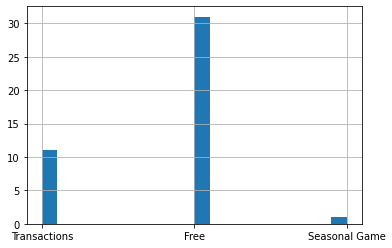

In [ ]:
campaign_feature["Campaign Type"].hist(bins=20)

In [ ]:
#One hot encoding as it's norminal 

# perform one-hot encoding
one_hot = pd.get_dummies(campaign_feature["Campaign Type"])

# concatenate the one-hot encoded dataframe with the original dataframe
campaign_feature = pd.concat([campaign_feature, one_hot], axis=1)



###Audience type


In [ ]:
campaign_feature["Audience Type (Private or Public)"].unique()

array(['Public', 'Private'], dtype=object)

<AxesSubplot:>

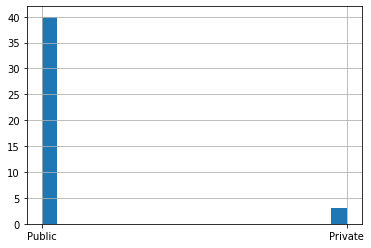

In [ ]:
campaign_feature["Audience Type (Private or Public)"].hist(bins=20)

In [ ]:
#One hot encoding as it's norminal 

# perform one-hot encoding
one_hot = pd.get_dummies(campaign_feature["Audience Type (Private or Public)"])

# concatenate the one-hot encoded dataframe with the original dataframe
campaign_feature = pd.concat([campaign_feature, one_hot], axis=1)



###Points/Rewards

In [ ]:
campaign_feature["Points/Rewards"].unique()

array(['Rewards', 'Coins', 'Points', 'Coins/Rewards'], dtype=object)

<AxesSubplot:>

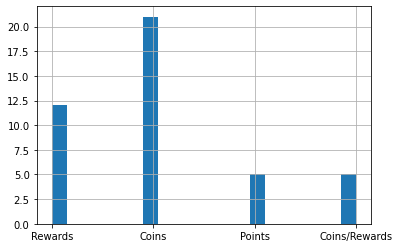

In [ ]:
campaign_feature["Points/Rewards"].hist(bins=20)

In [ ]:
campaign_feature["Points/Rewards"] = campaign_feature["Points/Rewards"].replace('Points', 'Coins')


In [ ]:
#One hot encoding as it's norminal 

# perform one-hot encoding
one_hot = pd.get_dummies(campaign_feature["Points/Rewards"])

# concatenate the one-hot encoded dataframe with the original dataframe
campaign_feature = pd.concat([campaign_feature, one_hot], axis=1)



###Max-Min Probability/rewards

In [ ]:
campaign_feature['Max Winning Rewards'] = pd.to_numeric(campaign_feature['Max Winning Rewards'].str.replace(',', '')) 
campaign_feature['Min Winning Rewards'] = pd.to_numeric(campaign_feature['Min Winning Rewards'].str.replace(',', '')) 


In [ ]:
campaign_feature['Max Winning Probability'] = pd.to_numeric(campaign_feature['Max Winning Probability'].str.replace('%', '')) / 100
campaign_feature['Min Winning Probability'] = pd.to_numeric(campaign_feature['Min Winning Probability'].str.replace('%', '')) / 100


###Final campaign dataframe

In [ ]:
campaign=campaign_feature.drop(['Campaign Name','Start Date','End Date','Campaign Type','Audience Type (Private or Public)','Points/Rewards'],axis=1)

In [ ]:
campaign.fillna(0,inplace=True)

In [ ]:
campaign.columns

Index(['Campaign ID', 'Max Winning Probability', 'Min Winning Probability',
       'Max Winning Rewards', 'Min Winning Rewards', 'duration', 'Free',
       'Seasonal Game', 'Transactions', 'Private', 'Public', 'Coins',
       'Coins/Rewards', 'Rewards'],
      dtype='object')

In [ ]:
campaign_reset= campaign.reset_index(drop=True)


In [ ]:
# Assume your data is in a dataframe called "campaign" with a column "column_to_ignore"
column_to_ignore = ['Campaign ID','Free', 'Seasonal Game', 'Transactions', 'Private','Public', 'Coins', 'Coins/Rewards', 'Rewards']

# Get the column names of the columns to be standardized
cols_to_standardize = [col for col in campaign_reset.columns if col not in column_to_ignore]

# Create a scaler object
scaler = StandardScaler()

# Standardize the columns to be standardized
campaign_standardized = pd.DataFrame(scaler.fit_transform(campaign[cols_to_standardize]), columns=cols_to_standardize)

# Add the column_to_ignore column back to the standardized data
# campaign_standardized[column_to_ignore] = campaign[column_to_ignore]

# Concatenate the original data and the standardized data along the column axis
campaign_final = pd.concat([campaign_standardized, campaign_reset[column_to_ignore]], axis=1)


In [ ]:
# campaign_final_without_my_column = campaign_final.drop(columns=['Campaign ID'])

# # Fill null values in the new DataFrame with 0
# campaign_final_without_my_column = campaign_final_without_my_column.fillna(value=0)

# # Add the 'my_column' column back to the DataFrame
# # campaign_final['Campaign ID'] = campaign_final['Campaign ID']

# # Alternatively, you can use pd.concat() to combine the two dataframes together
# campaign_final_data= pd.concat([campaign_final_without_my_column, campaign_final['Campaign ID']], axis=1)

In [ ]:
#add any rows that are to be removed
campaign_final_drop = campaign_final[~campaign_final['Campaign ID'].isin(['170','R-305', '239','CT','CP','NT'])]


In [ ]:
#training data
campaign_final_drop.to_csv('/content/drive/MyDrive/AI/Yoma/Yoma budget prediction/campaign_feature_standardized.csv', index=0)

In [ ]:
#Test data
campaign_final[campaign_final["Campaign ID"]=="170"].to_csv("/content/drive/MyDrive/AI/Yoma/Yoma budget prediction/Test data/170.csv",index=False)
campaign_final[campaign_final["Campaign ID"]=="R-305"].to_csv("/content/drive/MyDrive/AI/Yoma/Yoma budget prediction/Test data/R-305.csv",index=False)
campaign_final[campaign_final["Campaign ID"]=="239"].to_csv("/content/drive/MyDrive/AI/Yoma/Yoma budget prediction/Test data/239.csv",index=False)
campaign_final[campaign_final["Campaign ID"]=="CT"].to_csv("/content/drive/MyDrive/AI/Yoma/Yoma budget prediction/Test data/CT.csv",index=False)
campaign_final[campaign_final["Campaign ID"]=="CP"].to_csv("/content/drive/MyDrive/AI/Yoma/Yoma budget prediction/Test data/CP.csv",index=False)
campaign_final[campaign_final["Campaign ID"]=="NT"].to_csv("/content/drive/MyDrive/AI/Yoma/Yoma budget prediction/Test data/NT.csv",index=False)


##Final pocket user data

In [ ]:
# final_data.to_csv("C:/Users/shineminnkha/Documents/AI intern/Pocket data/final_data.csv") # export to csv file on local machine(campaign data)final_data
pocket_raw_raw=pd.read_csv('/content/drive/MyDrive/AI/Yoma/Yoma budget prediction/final_df.csv',index_col=0)

In [ ]:
print(pocket_raw_raw[pocket_raw_raw["is participated?"]==1].index)

Int64Index([     36,    1065,    1078,    1264,    1586,    1692,    1786,
               1922,    2086,    2150,
            ...
            2645821, 2645827, 2645846, 2656400, 2657746, 2658234, 2659121,
            2659191, 2660178, 2661582],
           dtype='int64', length=89901)


In [ ]:
print(len(pocket_raw_raw[pocket_raw_raw["is participated?"]==1]))
print(len(pocket_raw_raw[pocket_raw_raw["is participated?"]==0]))

#89422 =1
#1852778 =0

89901
2572119


In [ ]:
all_campaigns_by_user = pocket_raw_raw.groupby('user account').agg({'participated_campaign_frequency':'sum',
  'campaigns_point_earned':'sum', 'stamp_vouchers':'sum', 'stamp_expired_vouchers':'sum', 'game_vouchers':'sum',
  'game_expired_vouchers':'sum'}).reset_index()

print(all_campaigns_by_user)

pocket_raw = pd.merge(pocket_raw_raw[['user account', 'customer name_x', 'mobile phone_x', 'birthday',
       'perx registration date', 'state', 'email id', 'registration_source',
       'registerd_by_merchant', 'address1', 'city', 'home', 'gender',
       'nationality', 'valid_phone', 'campaign id', 'customer name_y',
       'mobile phone_y', 'merchant name', 'campaign name_x',
       'is participated?', 'campaign name_y','total_campaign_participated',
       'total_sales_point']],all_campaigns_by_user,on='user account',how='left')

                 user account  participated_campaign_frequency  \
0      10000229343-1669566523                             28.0   
1       1000195022-1669567054                              0.0   
2      10002620537-1669567460                             67.0   
3      10003593967-1669567470                              0.0   
4      10004198539-1669567706                              0.0   
...                       ...                              ...   
44362   9999800424-1669566268                              0.0   
44363                 9999999                             35.0   
44364               test_perx                              0.0   
44365             test_perx_2                              0.0   
44366             test_perx_3                              0.0   

       campaigns_point_earned  stamp_vouchers  stamp_expired_vouchers  \
0                      2200.0             0.0                     0.0   
1                         0.0             0.0                

In [ ]:
len(pocket_raw.index)

2662020

In [ ]:
pocket_raw.columns

Index(['user account', 'customer name_x', 'mobile phone_x', 'birthday',
       'perx registration date', 'state', 'email id', 'registration_source',
       'registerd_by_merchant', 'address1', 'city', 'home', 'gender',
       'nationality', 'valid_phone', 'campaign id', 'customer name_y',
       'mobile phone_y', 'merchant name', 'campaign name_x',
       'is participated?', 'campaign name_y', 'total_campaign_participated',
       'total_sales_point', 'participated_campaign_frequency',
       'campaigns_point_earned', 'stamp_vouchers', 'stamp_expired_vouchers',
       'game_vouchers', 'game_expired_vouchers'],
      dtype='object')

In [ ]:
pocket_raw['user account']=='10000229343-1669566523'
unique_values = pocket_raw[pocket_raw['user account'] == '10000229343-1669566523']['campaign id'].unique()

In [ ]:
len(unique_values)

60

In [ ]:
2582590+76130

2658720

In [ ]:
# 2658720-2122200
# 536520 extra data


In [ ]:
pocket_raw.isnull().sum()

user account                             0
customer name_x                     539820
mobile phone_x                      539880
birthday                            540060
perx registration date              539820
state                               539820
email id                            540060
registration_source                 539820
registerd_by_merchant              2662020
address1                           2662020
city                               2662020
home                               2662020
gender                              539880
nationality                        2662020
valid_phone                         539820
campaign id                              0
customer name_y                    2572119
mobile phone_y                     2572119
merchant name                      2572119
campaign name_x                    2572119
is participated?                         0
campaign name_y                          0
total_campaign_participated              0
total_sales

###data preprocessing for pocket data

In [ ]:
pocket_raw_without_my_column = pocket_raw.drop(columns=['gender'])

# Fill null values in the new rawFrame with 0
pocket_raw_without_my_column = pocket_raw_without_my_column.fillna(value=0)

# Add the 'my_column' column back to the rawFrame
# pocket_raw['Campaign ID'] = pocket_raw['Campaign ID']

# Alternatively, you can use pd.concat() to combine the two rawframes together
pocket_data_data= pd.concat([pocket_raw_without_my_column, pocket_raw['gender']], axis=1)

In [ ]:
#One hot encoding as it's norminal
# perform one-hot encoding
one_hot = pd.get_dummies(pocket_data_data["gender"])

# concatenate the one-hot encoded dataframe with the original dataframe
pocket_without_gender = pd.concat([pocket_data_data, one_hot], axis=1)


In [ ]:
pocket_without_gender.head()

,user account,customer name_x,mobile phone_x,birthday,perx registration date,state,email id,registration_source,registerd_by_merchant,address1,...,total_sales_point,participated_campaign_frequency,campaigns_point_earned,stamp_vouchers,stamp_expired_vouchers,game_vouchers,game_expired_vouchers,gender,f,m
0,10000229343-1669566523,""" HlaingYamin Oo""",9.597588e+11,2001-05-25,2022-11-27 22:58:43,active,xenom4249@gmail.com,sign_up_api,0.0,0.0,...,0,28.0,2200.0,0.0,0.0,2.0,1.0,f,1,0
1,10002620537-1669567460,""" PhoeAung""",9.599876e+11,1993-03-27,2022-11-27 23:14:20,active,min977776@gmail.com,sign_up_api,0.0,0.0,...,0,67.0,5170.0,0.0,0.0,3.0,0.0,m,0,1
2,1000195022-1669567054,""" MinKhant""",9.597525e+11,2005-04-05,2022-11-27 23:07:35,active,minkhant421@gmail.com,sign_up_api,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,f,1,0
3,10003593967-1669567470,0,0.000000e+00,0,0,0,0,0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,0
4,10005356280-1669568292,""" kaung htetnaing""",9.599581e+11,2002-07-07,2022-11-27 23:28:12,active,htetk73@gmail.com,sign_up_api,0.0,0.0,...,42,66.0,6850.0,0.0,0.0,3.0,0.0,m,0,1


In [ ]:
pocket_df=pocket_without_gender.drop(['customer name_x', 'mobile phone_x', 'birthday',
       'perx registration date', 'state', 'email id', 'registration_source','gender',
       'registerd_by_merchant', 'address1', 'city', 'home',
       'nationality', 'valid_phone', 'customer name_y',
       'mobile phone_y', 'merchant name', 'campaign name_x',
       'campaign name_y'],axis=1)

In [ ]:
pocket_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2662020 entries, 0 to 2662019
Data columns (total 13 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   user account                     object 
 1   campaign id                      object 
 2   is participated?                 int64  
 3   total_campaign_participated      int64  
 4   total_sales_point                int64  
 5   participated_campaign_frequency  float64
 6   campaigns_point_earned           float64
 7   stamp_vouchers                   float64
 8   stamp_expired_vouchers           float64
 9   game_vouchers                    float64
 10  game_expired_vouchers            float64
 11  f                                uint8  
 12  m                                uint8  
dtypes: float64(6), int64(3), object(2), uint8(2)
memory usage: 248.8+ MB


In [ ]:
# # final_data["user account"] = pd.to_numeric(final_data["user account"])
# # final_data= final_data.astype({"merchant name":'category', "campaign name":'category'})
# # final_data["user account"].astype(str).astype(int)
# # OneHotEncoder().fit_transform(final_data["merchant name"])

# categ = ['merchant name']

# # Encode Categorical Columns
# le = LabelEncoder()
# pocket_df[categ] = pocket_df[categ].apply(le.fit_transform)

# #view final df
# # convert to category or numerical value for merchant name, campaign name

###Standardization for pocket

In [ ]:
# Assume your data is in a dataframe called "pocket" with a column "column_to_ignore"
column_to_ignore = ['user account','campaign id','f','m','is participated?']
# Get the column names of the columns to be standardized
cols_to_standardize = [col for col in pocket_df.columns if col not in column_to_ignore]

# Create a scaler object
scaler = StandardScaler()

# Standardize the columns to be standardized
standardized_pocket = pd.DataFrame(scaler.fit_transform(pocket_df[cols_to_standardize]), columns=cols_to_standardize)

# Add the column_to_ignore column back to the standardized data
# pocket_standardized[column_to_ignore] = pocket[column_to_ignore]

# Concatenate the original data and the standardized data along the column axis
pocket_standardized = pd.concat([standardized_pocket, pocket_df[column_to_ignore]], axis=1)


In [ ]:
pocket_standardized.isnull().sum()

total_campaign_participated        0
total_sales_point                  0
participated_campaign_frequency    0
campaigns_point_earned             0
stamp_vouchers                     0
stamp_expired_vouchers             0
game_vouchers                      0
game_expired_vouchers              0
user account                       0
campaign id                        0
f                                  0
m                                  0
is participated?                   0
dtype: int64

In [ ]:
# for i in pocket.columns:
#   print(i+str(pocket[i].unique())+'/n')
# # ["Campaign Type"].unique()

In [ ]:
pocket_standardized.to_csv('/content/drive/MyDrive/AI/Yoma/Yoma budget prediction/pocket_standardized.csv', index=False)

In [ ]:
ps=pd.read_csv('/content/drive/MyDrive/AI/Yoma/Yoma budget prediction/pocket_standardized.csv')

##Combined campaign feature and user info

In [ ]:
#import standardized pocket data
pocket_campaign=pd.read_csv("/content/drive/MyDrive/AI/Yoma/Yoma budget prediction/campaign_feature_standardized.csv")
pocket_user=pd.read_csv("/content/drive/MyDrive/AI/Yoma/Yoma budget prediction/pocket_standardized.csv")



In [ ]:
print(len(pocket_campaign.index))
print(len(pocket_user.index))

37
2662020


In [ ]:
pocket_user.columns

Index(['total_campaign_participated', 'total_sales_point',
       'participated_campaign_frequency', 'campaigns_point_earned',
       'stamp_vouchers', 'stamp_expired_vouchers', 'game_vouchers',
       'game_expired_vouchers', 'user account', 'campaign id', 'f', 'm',
       'is participated?'],
      dtype='object')

In [ ]:
pocket_campaign['Campaign ID'] = pocket_campaign['Campaign ID'].astype(str)
pocket_user['campaign id'] = pocket_user['campaign id'].astype(str)
train_pocket = pd.merge(pocket_user,pocket_campaign,how='left',
                        left_on=['campaign id'],right_on=['Campaign ID'])

In [ ]:
# pocket_camp_user[pocket_camp_user['user account']=="10005356280-1669568292"]

In [ ]:
# pocket_final_data = pocket_camp_user.drop_duplicates(subset=['user account'], keep="first")

In [ ]:
print(len(train_pocket[train_pocket["is participated?"]==1]))
print(len(train_pocket[train_pocket["is participated?"]==0]))
# 89901
# 2572119

89901
2572119


##Pocket training data

In [ ]:
# pocket_final_data[pocket_final_data["Campaign ID"]=="R-305"]
# pocket_final_data[pocket_final_data["Campaign ID"]=="239"]


#2662020 total
#221835 3 values - 88734+44367+88734

# print the resulting dataframe

# len(pocket_final_data.index)

In [ ]:
len(train_pocket.index)

2662020

In [ ]:
train_pocket.dropna(inplace=True)

In [ ]:
len(train_pocket.index)

1641579

In [ ]:
train_pocket.isnull().sum()

total_campaign_participated        0
total_sales_point                  0
participated_campaign_frequency    0
campaigns_point_earned             0
stamp_vouchers                     0
stamp_expired_vouchers             0
game_vouchers                      0
game_expired_vouchers              0
user account                       0
campaign id                        0
f                                  0
m                                  0
is participated?                   0
Max Winning Probability            0
Min Winning Probability            0
Max Winning Rewards                0
Min Winning Rewards                0
duration                           0
Campaign ID                        0
Free                               0
Seasonal Game                      0
Transactions                       0
Private                            0
Public                             0
Coins                              0
Coins/Rewards                      0
Rewards                            0
d

##Pocket test data

In [ ]:
pocket_camp_user[pocket_camp_user["Campaign ID"]=="239"]

,total_campaign_participated,total_sales_point,participated_campaign_frequency,campaigns_point_earned,stamp_vouchers,stamp_expired_vouchers,game_vouchers,game_expired_vouchers,user account,campaign id,f,m,is participated?,Max Winning Probability,Min Winning Probability,Max Winning Rewards,Min Winning Rewards,duration,Campaign ID,Free,Seasonal Game,Transactions,Private,Public,Coins,Coins/Rewards,Rewards
1197909,2.068597,-0.048525,0.458859,0.458113,-0.035444,-0.023031,0.353618,1.965254,10000229343-1669566523,239,1,0,0,0.149385,-0.289674,-0.255838,-0.263211,0.162768,239,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
1197910,1.444800,-0.048525,1.714642,1.680954,-0.035444,-0.023031,0.700626,-0.237409,10002620537-1669567460,239,0,1,0,0.149385,-0.289674,-0.255838,-0.263211,0.162768,239,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
1197911,-0.426593,-0.048525,-0.442729,-0.447695,-0.035444,-0.023031,-0.340400,-0.237409,1000195022-1669567054,239,1,0,0,0.149385,-0.289674,-0.255838,-0.263211,0.162768,239,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
1197912,-0.738491,-0.048525,-0.442729,-0.447695,-0.035444,-0.023031,-0.340400,-0.237409,10003593967-1669567470,239,0,0,0,0.149385,-0.289674,-0.255838,-0.263211,0.162768,239,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
1197913,2.692394,-0.038007,1.682442,2.372662,-0.035444,-0.023031,0.700626,-0.237409,10005356280-1669568292,239,0,1,0,0.149385,-0.289674,-0.255838,-0.263211,0.162768,239,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1242271,-0.738491,-0.048525,-0.442729,-0.447695,-0.035444,-0.023031,-0.340400,-0.237409,test_perx_2,239,0,0,0,0.149385,-0.289674,-0.255838,-0.263211,0.162768,239,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
1242272,-0.738491,-0.048525,-0.442729,-0.447695,-0.035444,-0.023031,-0.340400,-0.237409,test_perx_3,239,0,0,0,0.149385,-0.289674,-0.255838,-0.263211,0.162768,239,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
1242273,-0.426593,-0.048525,-0.442729,-0.447695,-0.035444,-0.023031,-0.340400,-0.237409,999830925-1669566010,239,1,0,0,0.149385,-0.289674,-0.255838,-0.263211,0.162768,239,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
1242274,-0.426593,-0.048525,-0.442729,-0.447695,-0.035444,-0.023031,-0.340400,-0.237409,9999800424-1669566268,239,1,0,0,0.149385,-0.289674,-0.255838,-0.263211,0.162768,239,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0


In [ ]:
pocket_camp_user[pocket_camp_user["Campaign ID"]=="170"].to_csv("/content/drive/MyDrive/AI/Yoma budget prediction/Test data/170.csv",index=False)
pocket_camp_user[pocket_camp_user["Campaign ID"]=="R-305"].to_csv("/content/drive/MyDrive/AI/Yoma budget prediction/Test data/R-305.csv",index=False)
pocket_camp_user[pocket_camp_user["Campaign ID"]=="239"].to_csv("/content/drive/MyDrive/AI/Yoma budget prediction/Test data/239.csv",index=False)


FileNotFoundError: ignored

## Making balanced dataset

In [ ]:
len(train_pocket.index)

1641579

In [ ]:
print(len(train_pocket[train_pocket["is participated?"]==1]))
print(len(train_pocket[train_pocket["is participated?"]==0]))

88450
1553129


In [ ]:
train_pocket[train_pocket["is participated?"]==1].index


Int64Index([     36,    1065,    1078,    1264,    1586,    1692,    1786,
               1922,    2086,    2150,
            ...
            2582902, 2582903, 2582905, 2582906, 2582907, 2582908, 2582909,
            2582910, 2582917, 2582918],
           dtype='int64', length=88450)

In [ ]:
2528919-887340

1641579

In [ ]:
35370*40

1414800

In [ ]:
train_pocket.isnull().sum()

total_campaign_participated        0
total_sales_point                  0
participated_campaign_frequency    0
campaigns_point_earned             0
stamp_vouchers                     0
stamp_expired_vouchers             0
game_vouchers                      0
game_expired_vouchers              0
user account                       0
campaign id                        0
f                                  0
m                                  0
is participated?                   0
Max Winning Probability            0
Min Winning Probability            0
Max Winning Rewards                0
Min Winning Rewards                0
duration                           0
Campaign ID                        0
Free                               0
Seasonal Game                      0
Transactions                       0
Private                            0
Public                             0
Coins                              0
Coins/Rewards                      0
Rewards                            0
d

In [ ]:
# ['user account', 'customer name_x', 'mobile phone_x', 'birthday',
#        'perx registration date', 'state', 'email id', 'registration_source',
#        'registerd_by_merchant', 'address1', 'city', 'home', 'gender',
#        'nationality', 'valid_phone', 'campaign id', 'customer name_y',
#        'mobile phone_y', 'merchant name', 'campaign name_x',
#        'participated_campaign_frequency', 'campaigns_point_earned',
#        'stamp_vouchers', 'stamp_expired_vouchers', 'game_vouchers',
#        'game_expired_vouchers', 'is participated?', 'campaign name_y',
#        'Campaign ID', 'Campaign Name', 'Start Date', 'End Date',
#        'Campaign Type', 'Audience Type (Private or Public)', 'Points/Rewards',
#        'Max Winning Probability', 'Min Winning Probability',
#        'Max Winning Rewards', 'Min Winning Rewards', 'Total Spending']

In [ ]:
# pocket_df = pocket_camp_user.drop(labels=[84950,424884,424885,425096,425097,0,1,2,3,4], axis=0) 

In [ ]:
# print(len(pocket_df[pocket_df["is participated?"]==1]))
# print(len(pocket_df[pocket_df["is participated?"]==0]))

In [ ]:
no_participation=train_pocket[train_pocket['is participated?']==0].sample(n=88450,random_state=22)
participation=train_pocket[train_pocket['is participated?']==1].sample(n=88450,random_state=22) #
train_pocket_con=pd.concat([no_participation,participation],axis=0)
print("No participation",len(no_participation))
print("Participation",len(participation))

No participation 88450
Participation 88450


In [ ]:
print("train_pocket_con",len(train_pocket_con))

train_pocket_con 176900


In [ ]:
train_pocket_con.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 176900 entries, 183109 to 941174
Data columns (total 27 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   total_campaign_participated      176900 non-null  float64
 1   total_sales_point                176900 non-null  float64
 2   participated_campaign_frequency  176900 non-null  float64
 3   campaigns_point_earned           176900 non-null  float64
 4   stamp_vouchers                   176900 non-null  float64
 5   stamp_expired_vouchers           176900 non-null  float64
 6   game_vouchers                    176900 non-null  float64
 7   game_expired_vouchers            176900 non-null  float64
 8   user account                     176900 non-null  object 
 9   campaign id                      176900 non-null  object 
 10  f                                176900 non-null  int64  
 11  m                                176900 non-null  int64  
 1

In [ ]:
train_pocket_con.corr()

,total_campaign_participated,total_sales_point,participated_campaign_frequency,campaigns_point_earned,stamp_vouchers,stamp_expired_vouchers,game_vouchers,game_expired_vouchers,f,m,is participated?,Max Winning Probability,Min Winning Probability,Max Winning Rewards,Min Winning Rewards,duration,Free,Seasonal Game,Transactions,Private,Public,Coins,Coins/Rewards,Rewards
total_campaign_participated,1.000000,0.073831,0.761900,0.795705,0.143470,0.096354,0.590370,0.358439,0.143339,0.091866,0.606009,-0.227966,0.012380,0.096641,-0.083704,0.055853,0.140837,0.000009,-0.152453,-0.029997,0.029997,-0.003507,0.156903,-0.169771
total_sales_point,0.073831,1.000000,0.013224,0.027535,0.265212,0.177591,0.022824,0.026411,0.016079,-0.007204,0.016425,-0.001492,0.004417,-0.000413,0.002173,-0.000801,-0.001388,-0.001598,0.002239,-0.000020,0.000020,0.001219,-0.001062,-0.000245
participated_campaign_frequency,0.761900,0.013224,1.000000,0.968957,0.115650,0.081079,0.672477,0.250353,0.100644,0.059275,0.469679,-0.195684,0.023876,0.074021,-0.069674,0.044122,0.112570,-0.017031,-0.114009,-0.044004,0.044004,-0.012104,0.124365,-0.123696
campaigns_point_earned,0.795705,0.027535,0.968957,1.000000,0.122222,0.084155,0.614753,0.249729,0.096436,0.062427,0.473424,-0.186715,0.020615,0.065890,-0.065943,0.044530,0.102809,-0.005716,-0.108654,-0.034213,0.034213,0.004648,0.114154,-0.131908
stamp_vouchers,0.143470,0.265212,0.115650,0.122222,1.000000,0.555069,0.086899,0.023079,0.016565,-0.003002,0.049656,-0.015186,0.000229,-0.004164,0.002231,0.005791,-0.006687,-0.003331,0.008772,-0.005948,0.005948,0.008988,-0.004722,-0.005243
stamp_expired_vouchers,0.096354,0.177591,0.081079,0.084155,0.555069,1.000000,0.090919,0.024250,0.011305,-0.002271,0.032013,-0.009387,0.001618,-0.003069,0.002911,0.003437,-0.003359,0.001145,0.003109,-0.000626,0.000626,0.005814,-0.002921,-0.003541
game_vouchers,0.590370,0.022824,0.672477,0.614753,0.086899,0.090919,1.000000,0.376581,0.098526,0.015098,0.334396,-0.109653,0.022331,0.031335,-0.047345,0.033596,0.081294,-0.002387,-0.086898,-0.016848,0.016848,-0.011215,0.055106,-0.047989
game_expired_vouchers,0.358439,0.026411,0.250353,0.249729,0.023079,0.024250,0.376581,1.000000,0.055977,0.014647,0.198051,-0.047963,0.003909,0.009091,-0.024076,0.020053,0.046197,0.008149,-0.053759,0.001659,-0.001659,0.008952,0.029672,-0.043313
f,0.143339,0.016079,0.100644,0.096436,0.016565,0.011305,0.098526,0.055977,1.000000,-0.804366,0.129497,-0.045831,-0.001863,0.033913,-0.025991,0.016769,0.033759,-0.004935,-0.034270,-0.006315,0.006315,-0.032090,0.050092,-0.018103
m,0.091866,-0.007204,0.059275,0.062427,-0.003002,-0.002271,0.015098,0.014647,-0.804366,1.000000,0.085613,-0.033204,0.000404,0.025479,-0.009326,0.003224,0.022522,-0.008368,-0.020526,-0.013939,0.013939,-0.016585,0.040408,-0.025444


In [ ]:
print(len(participation))
print(len(no_participation))

88450
88450


In [ ]:
88450*0.8

70760.0

In [ ]:
1641579*0.8

1313263.2000000002

In [ ]:
1641579*0.2

328315.80000000005

In [ ]:
#80% for training no-balance

print("no participation",len(no_participation[0:70760]))
print("participation",len(participation[0:70760]))
tnp=no_participation[0:70760]
tp=participation[0:70760]
train=pd.concat([tnp,tp],axis=0)

# train=train_pocket[0:1313263]
# print(len(train))
# print(type(train))

no participation 70760
participation 70760


In [ ]:
# #20% for validation

print("no participation",len(no_participation[70760:]))
print("participation",len(participation[70760:]))
vnp=no_participation[70760:]
vp=participation[70760:]
val=pd.concat([vnp,vp],axis=0)

# print(len(val))
# print(type(val))

no participation 17690
participation 17690


In [ ]:
X_train=train.drop(['campaign id','is participated?','Campaign ID','user account'],axis=1)
X_val=val.drop(['campaign id','is participated?','Campaign ID','user account'],axis=1)


In [ ]:
y_train=train["is participated?"] 
y_val=val["is participated?"]

## Model training with orginal data(version 1-user feature only)

In [ ]:
scaled_data.head()

,participated_campaign_frequency,campaigns_point_earned,stamp_vouchers,stamp_expired_vouchers,game_vouchers,game_expired_vouchers,sales_points_earned,Total campaign participated
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(scaled_data, target, test_size=0.1, random_state=42,shuffle=True)

# In the first step we will split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(scaled_data, target, train_size=0.8, random_state=42,shuffle=True)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)

X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

(1553756, 8)
(1553756,)
(194220, 8)
(194220,)
(194220, 8)
(194220,)


(None, None)

### Random Forest Classifier

In [ ]:
classifier=RandomForestClassifier()
classifier=classifier.fit(X_train,y_train)
y_pred_rf=classifier.predict(X_test)
print(accuracy_score(y_test,y_pred_rf))


1.0


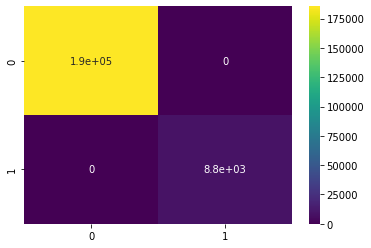

In [ ]:
import seaborn as sns
sns.heatmap(confusion_matrix(y_test,y_pred_rf),cmap='viridis',annot=True);   

In [ ]:
print ('Report : ')
print (classification_report(y_test,y_pred_rf))

Report : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    185392
           1       1.00      1.00      1.00      8828

    accuracy                           1.00    194220
   macro avg       1.00      1.00      1.00    194220
weighted avg       1.00      1.00      1.00    194220



In [ ]:
# Save the trained model as a pickle string.
saved_model = pickle.dumps(classifier)
  
# Load the pickled model
rfc_from_pickle = pickle.loads(saved_model)
  

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
lr.fit(X_train,y_train)
y_pred_lr=lr.predict(X_valid)
print("Accuracy",accuracy_score(y_test,y_pred_lr))


0.9543352898774585


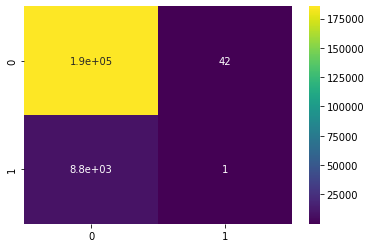

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred_lr),cmap='viridis',annot=True);   

In [ ]:
print ('Report : ')
print (classification_report(y_test, y_pred_lr))

Report : 
              precision    recall  f1-score   support

           0       0.95      1.00      0.98    185392
           1       0.02      0.00      0.00      8828

    accuracy                           0.95    194220
   macro avg       0.49      0.50      0.49    194220
weighted avg       0.91      0.95      0.93    194220



In [ ]:
# Save the trained model as a pickle string.
saved_model = pickle.dumps(lr)
  
# Load the pickled model
lr_from_pickle = pickle.loads(saved_model)
  


### Decision Trees

In [ ]:
# Create Decision Tree classifier object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)

# Train Decision Tree Classifier
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred_clf = clf.predict(X_valid)
print(accuracy_score(y_test,y_pred_clf))

0.912408608794151


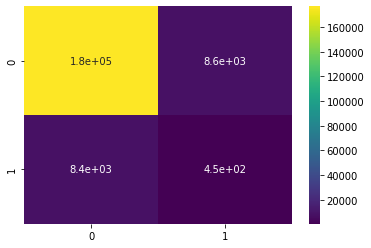

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred_clf),cmap='viridis',annot=True);   

In [ ]:
print ('Report : ')
print (classification_report(y_test, y_pred_clf))

Report : 
              precision    recall  f1-score   support

           0       0.95      0.95      0.95    185392
           1       0.05      0.05      0.05      8828

    accuracy                           0.91    194220
   macro avg       0.50      0.50      0.50    194220
weighted avg       0.91      0.91      0.91    194220



In [ ]:
# Save the trained model as a pickle string.
saved_model = pickle.dumps(clf)

# Load the pickled model
clf_from_pickle = pickle.loads(saved_model)
  

### K nearest neighbour

In [ ]:
# knn = KNeighborsClassifier(n_neighbors=7)
# knn.fit(X_train, y_train)
# y_pred_knn=knn.predict(X_test)
# # Predict on dataset which model has not seen before
# print(accuracy_score(y_test,y_pred_knn))

In [ ]:
import seaborn as sns
sns.heatmap(confusion_matrix(y_test,y_pred_knn),cmap='viridis',annot=True);   

In [ ]:
print ('Report : ')
print (classification_report(y_test, y_pred_knn))

In [ ]:
# Save the trained model as a pickle string.
saved_model = pickle.dumps(knn)
  
# Load the pickled model
knn_from_pickle = pickle.loads(saved_model)
  

### Naive Bayes Algorithm

In [ ]:
# Training the Naive Bayes model on the Training set
nb = GaussianNB()
nb.fit(X_train, y_train)

# Predicting the Test set results
y_pred_nb = nb.predict(X_test)

# Making the Confusion Matrix
print(accuracy_score(y_test,y_pred_nb))

1.0


In [ ]:
print ('Report : ')
print (classification_report(y_test,y_pred_nb))

In [ ]:
# Save the trained model as a pickle string.
saved_model = pickle.dumps(nb)
  
# Load the pickled model
nb_from_pickle = pickle.loads(saved_model)
  


array([0, 0, 0, ..., 0, 0, 0])

### Support Vector Machine

In [ ]:
svm = SVC(kernel='linear', random_state=0)  
svm.fit(X_train, y_train) 
y_pred_svm= svm.predict(X_test)  
print(accuracy_score(y_test,y_pred_svm))

In [ ]:
print ('Report : ')
print (classification_report(y_test,y_pred_svm))

In [ ]:
# Save the trained model as a pickle string.
saved_model = pickle.dumps(svm)
  
# Load the pickled model
svm_from_pickle = pickle.loads(saved_model)
  
# Use the loaded pickled model to make predictions


## Testing data with the trained model(version 1-user feature only)

In [ ]:
pocket_test=pocket_df.drop(['campaign id','is participated?','participation status','customer name','mobile phone','user account','campaign name_x', 'campaign name_y','merchant name'],axis=1)

In [ ]:
pocket_test.isnull().sum()

participated_campaign_frequency    0
campaigns_point_earned             0
stamp_vouchers                     0
stamp_expired_vouchers             0
game_vouchers                      0
game_expired_vouchers              0
sales_points_earned                0
Total campaign participated        0
dtype: int64

In [ ]:
index_list = [28,1026,0,1]
test_pocket = pocket_test.loc[pocket_test.index[index_list]]
# print(test_pocket)

In [ ]:
# Use the loaded pickled model to make predictions
print("Random Forest Classifier result =",rfc_from_pickle.predict(test_pocket))
print("Logistic regression result =",lr_from_pickle.predict(test_pocket))
print("Decision Tree result =",clf_from_pickle.predict(test_pocket))


Random Forest Classifier result = [1 1 0 0]
Logistic regression result = [1 1 0 0]
Decision Tree result = [1 1 0 0]


## Model training with balanced data(version 2-user feature only)

In [ ]:
X_train, X_val_test, y_train, y_val_test

(        participated_campaign_frequency  campaigns_point_earned  \
 0                              0.000000                0.000000   
 1                              0.000000                0.000000   
 2                              0.000000                0.000000   
 3                              0.000000                0.000000   
 4                              0.000000                0.000000   
 ...                                 ...                     ...   
 143069                         0.000324                0.000833   
 143070                         0.000324                0.000833   
 143071                         0.000971                0.000417   
 143072                         0.005505                0.004207   
 143073                         0.000648                0.000250   
 
         stamp_vouchers  stamp_expired_vouchers  game_vouchers  \
 0                  0.0                     0.0       0.000000   
 1                  0.0                     0.0   

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(scaled_data, target, test_size=0.1, random_state=42,shuffle=True)

# In the first step we will split the data in training and remaining dataset
# X_train, X_rem, y_train, y_rem = train_test_split(scaled_data, target, train_size=0.8, random_state=42,shuffle=True)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)

# X_valid, X_test, y_valid, y_test = train_test_split(X_val_test,y_val_test, test_size=0.5)

print(X_train.shape), print(y_train.shape)
print(X_val_test.shape), print(y_val_test.shape)
# print(X_test.shape), print(y_test.shape)

(143072, 8)
(143072,)
(35768, 8)
(35768,)


(None, None)

###Radom forest classifer

Accuracy: 1.0
Report : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17884
           1       1.00      1.00      1.00     17884

    accuracy                           1.00     35768
   macro avg       1.00      1.00      1.00     35768
weighted avg       1.00      1.00      1.00     35768



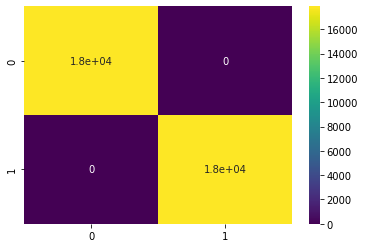

In [ ]:
classifier=RandomForestClassifier()
classifier=classifier.fit(X_train,y_train)
y_pred_rf=classifier.predict(X_val_test)
print("Accuracy:",accuracy_score(y_val_test,y_pred_rf))

import seaborn as sns
sns.heatmap(confusion_matrix(y_val_test,y_pred_rf),cmap='viridis',annot=True);   

print ('Report : ')
print (classification_report(y_val_test,y_pred_rf))

In [ ]:
# Save the trained model as a pickle string.
saved_model = pickle.dumps(classifier)
  
# Load the pickled model
rfc_from_pickle = pickle.loads(saved_model)
  

###Logistic Regression

Accuracy 0.8231939163498099
Report : 
              precision    recall  f1-score   support

           0       0.74      1.00      0.85     17884
           1       1.00      0.65      0.79     17884

    accuracy                           0.82     35768
   macro avg       0.87      0.82      0.82     35768
weighted avg       0.87      0.82      0.82     35768



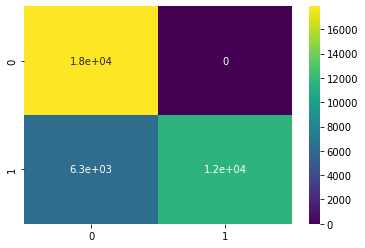

In [ ]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
lr.fit(X_train,y_train)
y_pred_lr=lr.predict(X_val_test)
print("Accuracy",accuracy_score(y_val_test,y_pred_lr))

sns.heatmap(confusion_matrix(y_val_test,y_pred_lr),cmap='viridis',annot=True);   

print ('Report : ')
print (classification_report(y_val_test, y_pred_lr))

In [ ]:
# Save the trained model as a pickle string.
saved_model = pickle.dumps(lr)

# Load the pickled model
lr_from_pickle = pickle.loads(saved_model)
  


###Decision Tree

1.0
Report : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17884
           1       1.00      1.00      1.00     17884

    accuracy                           1.00     35768
   macro avg       1.00      1.00      1.00     35768
weighted avg       1.00      1.00      1.00     35768



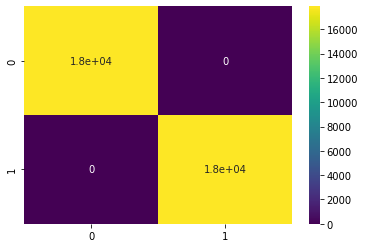

In [ ]:
# Create Decision Tree classifier object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)

# Train Decision Tree Classifier
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred_clf = clf.predict(X_val_test)
print(accuracy_score(y_val_test,y_pred_clf))

sns.heatmap(confusion_matrix(y_val_test,y_pred_clf),cmap='viridis',annot=True);
print ('Report : ')
print (classification_report(y_val_test, y_pred_clf))   

In [ ]:
# Save the trained model as a pickle string.
saved_model = pickle.dumps(clf)
# Load the pickled model
clf_from_pickle = pickle.loads(saved_model)



###Naive Bayes

1.0
Report : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17884
           1       1.00      1.00      1.00     17884

    accuracy                           1.00     35768
   macro avg       1.00      1.00      1.00     35768
weighted avg       1.00      1.00      1.00     35768



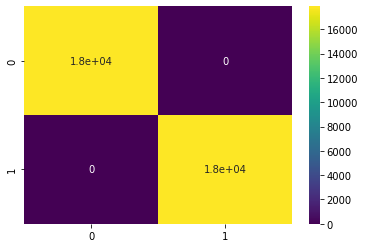

In [ ]:
# Training the Naive Bayes model on the Training set
nb = GaussianNB()
nb.fit(X_train, y_train)

# Predicting the Test set results
y_pred_nb = nb.predict(X_val_test)

# Making the Confusion Matrix
print(accuracy_score(y_val_test,y_pred_nb))

sns.heatmap(confusion_matrix(y_val_test,y_pred_clf),cmap='viridis',annot=True);
print ('Report : ')
print (classification_report(y_val_test, y_pred_clf))   

In [ ]:
# Save the trained model as a pickle string.
saved_model = pickle.dumps(nb)
# Load the pickled model
nb_from_pickle = pickle.loads(saved_model)

## Testing data with the balanced trained model(version 2-user feature only)

In [ ]:
# Use the loaded pickled model to make predictions
print("Random Forest Classifier result =",rfc_from_pickle.predict(test_pocket))
print("Logistic regression result =",lr_from_pickle.predict(test_pocket))
print("Decision Tree result =",clf_from_pickle.predict(test_pocket))
print("Naive Bayes result =",nb_from_pickle.predict(test_pocket))


Random Forest Classifier result = [1 1 0 0]
Logistic regression result = [1 1 0 0]
Decision Tree result = [1 1 0 0]
Naive Bayes result = [1 1 0 0]


## Model training with balanced data(version 3 - user and campaign)

In [ ]:
print(X_train.shape), print(y_train.shape)
print(X_val.shape), print(y_val.shape)

(141520, 23)
(141520,)
(35380, 23)
(35380,)


(None, None)

###Radom Forest Classifier

Accuracy: 96.28%
Report : 
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     17690
           1       0.95      0.97      0.96     17690

    accuracy                           0.96     35380
   macro avg       0.96      0.96      0.96     35380
weighted avg       0.96      0.96      0.96     35380



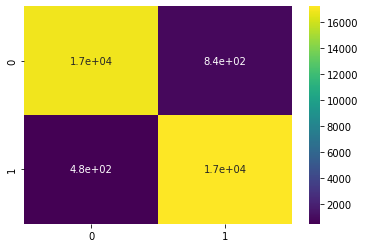

In [ ]:
classifier = RandomForestClassifier(n_estimators=40, max_depth=20, random_state=42)
classifier=classifier.fit(X_train,y_train)
y_pred_rf=classifier.predict(X_val)
classifier_acc=accuracy_score(y_val,y_pred_rf) *100
print("Accuracy: {:.2f}%".format(classifier_acc))

sns.heatmap(confusion_matrix(y_val,y_pred_rf),cmap='viridis',annot=True);   

print ('Report : ')
print (classification_report(y_val,y_pred_rf))


In [ ]:
# save the trained model to a file
with open('/content/drive/MyDrive/AI/Yoma/Yoma budget prediction/Models/random_forest_model.pkl', 'wb') as f:
    pickle.dump(classifier, f)


In [ ]:
# # Authenticate and authorize Google Drive API access
# creds = Credentials.from_authorized_user_file('/content/drive/MyDrive/AI/Yoma/Yoma budget prediction/Models/budget-prediction-379502-017db7c25887.json', ['https://www.googleapis.com/auth/drive'])

# # Define path to save the model in Google Drive
# drive_folder_id = '/content/drive/MyDrive/AI/Yoma/Yoma budget prediction/Models'  # Replace with the ID of the Google Drive folder where you want to save the model
# model_name = 'my_rfc_model.pkl'  # Replace with the name you want to give the model file

# # Serialize and save the trained model to a file
# with open(model_name, 'wb') as file:
#     pickle.dump(rfc_from_pickle, file)

# # Upload the model file to Google Drive
# try:
#     # Create the Google Drive API client
#     drive_service = build('drive', 'v3', credentials=creds)
    
#     # Create metadata for the file
#     file_metadata = {'name': model_name, 'parents': [drive_folder_id]}
    
#     # Upload the file to Google Drive
#     media = MediaFileUpload(model_name, resumable=True)
#     file = drive_service.files().create(body=file_metadata, media_body=media, fields='id').execute()
    
#     # Print the ID of the uploaded file
#     print('File ID: %s' % file.get('id'))
    
# except HttpError as error:
#     print('An error occurred: %s' % error)
#     file = None

# # Remove the local file
# os.remove(model_name)


###Decision Tree

0.8558507631430187
Report : 
              precision    recall  f1-score   support

           0       0.80      0.94      0.87     17690
           1       0.93      0.77      0.84     17690

    accuracy                           0.86     35380
   macro avg       0.87      0.86      0.85     35380
weighted avg       0.87      0.86      0.85     35380



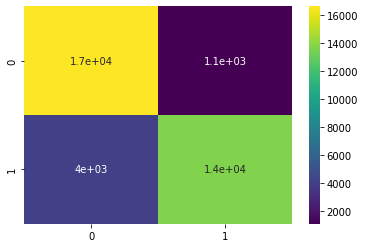

In [ ]:
# Create Decision Tree classifier object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)

# Train Decision Tree Classifier
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred_clf = clf.predict(X_val)
dt_acc=accuracy_score(y_val,y_pred_clf)
print(dt_acc)

sns.heatmap(confusion_matrix(y_val,y_pred_clf),cmap='viridis',annot=True);
print ('Report : ')
print (classification_report(y_val, y_pred_clf))   

In [ ]:
# save the trained model to a file
with open('/content/drive/MyDrive/AI/Yoma/Yoma budget prediction/Models/decision_tree_model.pkl', 'wb') as f:
    pickle.dump(clf, f)

###Logistic regression

Accuracy 0.8783776144714528
Report : 
              precision    recall  f1-score   support

           0       0.89      0.86      0.88     17690
           1       0.86      0.90      0.88     17690

    accuracy                           0.88     35380
   macro avg       0.88      0.88      0.88     35380
weighted avg       0.88      0.88      0.88     35380



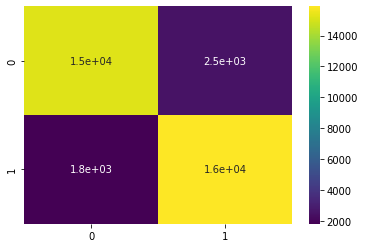

In [ ]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
lr.fit(X_train,y_train)
y_pred_lr=lr.predict(X_val)
lr_acc=accuracy_score(y_val,y_pred_lr)
print("Accuracy",lr_acc)

sns.heatmap(confusion_matrix(y_val,y_pred_lr),cmap='viridis',annot=True);   

print ('Report : ')
print (classification_report(y_val, y_pred_lr))

In [ ]:
# save the trained model to a file
with open('/content/drive/MyDrive/AI/Yoma/Yoma budget prediction/Models/logistic_regression_model.pkl', 'wb') as f:
    pickle.dump(lr, f)

###Support Vector Machines

In [ ]:
from sklearn import svm
# create the SVM classifier
svm = svm.SVC(kernel='linear', C=1.0, random_state=42)

# train the classifier
svm.fit(X_train, y_train)

# make predictions on the test set
y_pred_svm = svm.predict(X_val)

# evaluate the model
svm_acc=accuracy_score(y_val, y_pred_svm)
print('Accuracy:', svm_acc)
sns.heatmap(confusion_matrix(y_val,y_pred_svm),cmap='viridis',annot=True);   
print('Classification Report:\n', classification_report(y_val, y_pred_svm))


In [ ]:
# save the trained model to a file
with open('/content/drive/MyDrive/AI/Yoma/Yoma budget prediction/Models/support_vector_machine_model.pkl', 'wb') as f:
    pickle.dump(svm, f)

###Naive Bayes Classifier

In [ ]:
from sklearn.naive_bayes import GaussianNB
# create the nb classifier
nb = GaussianNB()

# train the classifier
nb.fit(X_train, y_train)

# make predictions on the test set
y_pred_nb = nb.predict(X_val)

# evaluate the model
print('Accuracy:', accuracy_score(y_val, y_pred_nb))
sns.heatmap(confusion_matrix(y_val,y_pred_nb),cmap='viridis',annot=True);   
print('Classification Report:\n', classification_report(y_val, y_pred_nb))


###K nearest neighbour

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Create KNN classifier
knn = KNeighborsClassifier(n_neighbors = 3)

# Fit the classifier to the data
knn.fit(X_train, y_train)

# make predictions on the test set
y_pred_knn = knn.predict(X_val)

# evaluate the model
knn_acc=accuracy_score(y_val, y_pred_knn)
print('Accuracy:', knn_acc)
sns.heatmap(confusion_matrix(y_val,y_pred_knn),cmap='viridis',annot=True);   
print('Classification Report:\n', classification_report(y_val, y_pred_knn))


In [ ]:
# save the trained model to a file
with open('/content/drive/MyDrive/AI/Yoma/Yoma budget prediction/Models/k_nearest_neighbour_model.pkl', 'wb') as f:
    pickle.dump(knn, f)

###Gradient Boosting Machines

Accuracy: 0.9485585076314302
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.95     17690
           1       0.94      0.95      0.95     17690

    accuracy                           0.95     35380
   macro avg       0.95      0.95      0.95     35380
weighted avg       0.95      0.95      0.95     35380



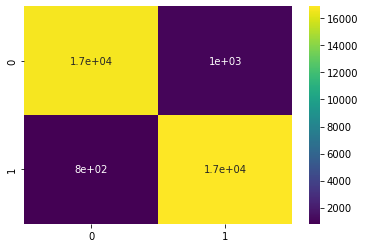

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Create GBM classifier
gbm = GradientBoostingClassifier()

# Fit the classifier to the data
gbm.fit(X_train, y_train)

# make predictions on the test set
y_pred_gbm = gbm.predict(X_val)

# evaluate the model
gbm_acc=accuracy_score(y_val, y_pred_gbm)
print('Accuracy:', gbm_acc)
sns.heatmap(confusion_matrix(y_val,y_pred_gbm),cmap='viridis',annot=True);   
print('Classification Report:\n', classification_report(y_val, y_pred_gbm))


In [ ]:
# save the trained model to a file
with open('/content/drive/MyDrive/AI/Yoma/Yoma budget prediction/Models/Gradient Boosting Machines.pkl', 'wb') as f:
    pickle.dump(gbm, f)

###XGBoost

Accuracy: 0.9424816280384398
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94     17690
           1       0.93      0.95      0.94     17690

    accuracy                           0.94     35380
   macro avg       0.94      0.94      0.94     35380
weighted avg       0.94      0.94      0.94     35380



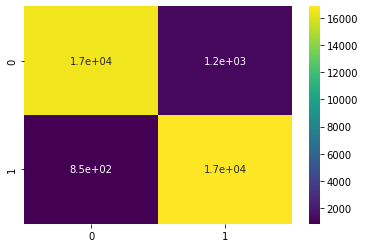

In [ ]:
import xgboost as xgb

# Convert the training and test data to DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_val, label=y_val)

# Define the hyperparameters for the XGBoost model
params = {
    'max_depth': 3,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}

# Train the XGBoost model
num_rounds = 100
xgb_model = xgb.train(params, dtrain, num_rounds)

# Make predictions on the test set
y_pred = xgb_model.predict(dtest)

# Convert probabilities into binary predictions
y_pred_binary = [round(value) for value in y_pred]

# Calculate the accuracy score
xgb_accuracy = accuracy_score(y_val, y_pred_binary)

# Print the accuracy score
print("Accuracy:", xgb_accuracy)
sns.heatmap(confusion_matrix(y_val,y_pred_binary),cmap='viridis',annot=True);   
print('Classification Report:\n', classification_report(y_val, y_pred_binary))


In [ ]:
# save the trained model to a file
with open('/content/drive/MyDrive/AI/Yoma/Yoma budget prediction/Models/XGBoost.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

###CatBoost

Learning rate set to 0.085375
0:	learn: 0.5664774	total: 161ms	remaining: 2m 40s
1:	learn: 0.4719778	total: 274ms	remaining: 2m 16s
2:	learn: 0.3958149	total: 365ms	remaining: 2m 1s
3:	learn: 0.3333051	total: 525ms	remaining: 2m 10s
4:	learn: 0.2879363	total: 693ms	remaining: 2m 17s
5:	learn: 0.2630632	total: 823ms	remaining: 2m 16s
6:	learn: 0.2389540	total: 958ms	remaining: 2m 15s
7:	learn: 0.2283207	total: 1.09s	remaining: 2m 15s
8:	learn: 0.2144623	total: 1.24s	remaining: 2m 16s
9:	learn: 0.2033595	total: 1.36s	remaining: 2m 14s
10:	learn: 0.1939207	total: 1.46s	remaining: 2m 11s
11:	learn: 0.1871658	total: 1.58s	remaining: 2m 10s
12:	learn: 0.1801550	total: 1.72s	remaining: 2m 10s
13:	learn: 0.1744020	total: 1.86s	remaining: 2m 11s
14:	learn: 0.1697021	total: 2.01s	remaining: 2m 12s
15:	learn: 0.1651652	total: 2.12s	remaining: 2m 10s
16:	learn: 0.1622498	total: 2.27s	remaining: 2m 11s
17:	learn: 0.1568793	total: 2.4s	remaining: 2m 10s
18:	learn: 0.1545839	total: 2.56s	remaining: 2

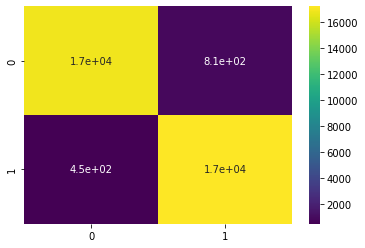

In [ ]:
from catboost import CatBoostClassifier
cb = CatBoostClassifier()


# Fit the classifier to the data
cb.fit(X_train, y_train)

# make predictions on the test set
y_pred_cb = cb.predict(X_val)

# evaluate the model
cb_acc=accuracy_score(y_val, y_pred_cb)
print('Accuracy:', cb_acc)
sns.heatmap(confusion_matrix(y_val,y_pred_cb),cmap='viridis',annot=True);   
print('Classification Report:\n', classification_report(y_val, y_pred_cb))


In [ ]:
# save the trained model to a file
with open('/content/drive/MyDrive/AI/Yoma/Yoma budget prediction/Models/CatBoost.pkl', 'wb') as f:
    pickle.dump(cb, f)

###Lightgbm


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 70760, number of negative: 70760
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.202411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 886
[LightGBM] [Info] Number of data points in the train set: 141520, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Accuracy: 0.9611927642736009
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96     17690
           1       0.95      0.97      0.96     17690

    accuracy                           0.96     35380
   macro avg       0.96      0.96      0.96     35380
weighted avg       0.96      0.96      0.96     35380



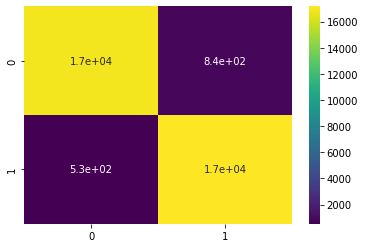

In [ ]:
import lightgbm as lgb

# Create the LightGBM dataset format
train_data = lgb.Dataset(X_train, label=y_train)

# Set the hyperparameters
params = {'objective': 'binary', 'metric': 'binary_logloss'}

# Train the model
lgb_model = lgb.train(params, train_data)

# Predict on the val set
y_pred = lgb_model.predict(X_val)
y_pred_binary = [1 if x >= 0.5 else 0 for x in y_pred]

# Calculate the accuracy score
lgb_accuracy = accuracy_score(y_val, y_pred_binary)

# evaluate the model
print('Accuracy:', lgb_accuracy)
sns.heatmap(confusion_matrix(y_val,y_pred_binary),cmap='viridis',annot=True);   
print('Classification Report:\n', classification_report(y_val, y_pred_binary))







In [ ]:
# save the trained model to a file
with open('/content/drive/MyDrive/AI/Yoma/Yoma budget prediction/Models/lightgbm.pkl', 'wb') as f:
    pickle.dump(lgb_model, f)

###Adamboost 

Accuracy: 0.9151215375918598
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.91      0.92     17690
           1       0.91      0.92      0.92     17690

    accuracy                           0.92     35380
   macro avg       0.92      0.92      0.92     35380
weighted avg       0.92      0.92      0.92     35380



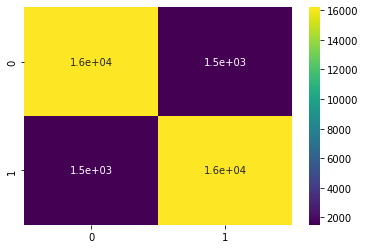

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(n_estimators=50, learning_rate=1.0, random_state=42)

# Train the model
ada.fit(X_train, y_train)

# Predict on the val set
y_pred_ada = ada.predict(X_val)

# evaluate the model
ada_accuracy = accuracy_score(y_val, y_pred_ada)

print('Accuracy:', ada_accuracy)
sns.heatmap(confusion_matrix(y_val,y_pred_ada),cmap='viridis',annot=True);   
print('Classification Report:\n', classification_report(y_val, y_pred_ada))


In [ ]:
# save the trained model to a file
with open('/content/drive/MyDrive/AI/Yoma/Yoma budget prediction/Models/AdaBoost.pkl', 'wb') as f:
    pickle.dump(ada, f)

##Ensemble model

Learning rate set to 0.085375
0:	learn: 0.5664774	total: 134ms	remaining: 2m 13s
1:	learn: 0.4719778	total: 218ms	remaining: 1m 48s
2:	learn: 0.3958149	total: 317ms	remaining: 1m 45s
3:	learn: 0.3333051	total: 409ms	remaining: 1m 41s
4:	learn: 0.2879363	total: 514ms	remaining: 1m 42s
5:	learn: 0.2630632	total: 602ms	remaining: 1m 39s
6:	learn: 0.2389540	total: 688ms	remaining: 1m 37s
7:	learn: 0.2283207	total: 800ms	remaining: 1m 39s
8:	learn: 0.2144623	total: 894ms	remaining: 1m 38s
9:	learn: 0.2033595	total: 997ms	remaining: 1m 38s
10:	learn: 0.1939207	total: 1.06s	remaining: 1m 35s
11:	learn: 0.1871658	total: 1.17s	remaining: 1m 36s
12:	learn: 0.1801550	total: 1.27s	remaining: 1m 36s
13:	learn: 0.1744020	total: 1.38s	remaining: 1m 37s
14:	learn: 0.1697021	total: 1.5s	remaining: 1m 38s
15:	learn: 0.1651652	total: 1.6s	remaining: 1m 38s
16:	learn: 0.1622498	total: 1.72s	remaining: 1m 39s
17:	learn: 0.1568793	total: 1.82s	remaining: 1m 39s
18:	learn: 0.1545839	total: 1.94s	remaining: 1

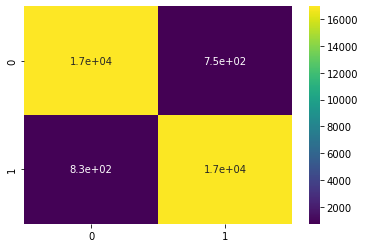

In [ ]:
# Load the first trained model
with open('/content/drive/MyDrive/AI/Yoma/Yoma budget prediction/Models/random_forest_model.pkl', 'rb') as f:
    rfc = pickle.load(f)

# Load the second trained model
with open('/content/drive/MyDrive/AI/Yoma/Yoma budget prediction/Models/Gradient Boosting Machines.pkl', 'rb') as f:
    gbm = pickle.load(f)

# with open('/content/drive/MyDrive/AI/Yoma/Yoma budget prediction/Models/XGBoost.pkl', 'rb') as f:
#     xgb = pickle.load(f)

with open('/content/drive/MyDrive/AI/Yoma/Yoma budget prediction/Models/CatBoost.pkl', 'rb') as f:
    cb = pickle.load(f)

# with open('/content/drive/MyDrive/AI/Yoma/Yoma budget prediction/Models/lightgbm.pkl', 'rb') as f:
#     lgbm = pickle.load(f)

with open('/content/drive/MyDrive/AI/Yoma/Yoma budget prediction/Models/AdaBoost.pkl', 'rb') as f:
    ada = pickle.load(f)

# Create a voting classifier to combine the two models
ensemble_model = VotingClassifier(estimators=[('model1', rfc), ('model2', gbm),('model3', ada),('model4', cb)])

# Train the ensemble model on your training data
ens=ensemble_model.fit(X_train, y_train)

#Predict the response for test dataset
y_pred_ens= ens.predict(X_val)
ens_acc=accuracy_score(y_val,y_pred_ens)
print(ens_acc)

sns.heatmap(confusion_matrix(y_val,y_pred_ens),cmap='viridis',annot=True);
print ('Report : ')
print (classification_report(y_val, y_pred_ens))   

In [ ]:
# save the trained model to a file
with open('/content/drive/MyDrive/AI/Yoma/Yoma budget prediction/Models/ensemble_model.pkl', 'wb') as f:
    pickle.dump(ens, f)


## Testing data with the balanced trained model(version 3-user feature and campaign)

###Load saved model 

In [ ]:
# Load rfc model
with open('/content/drive/MyDrive/AI/Yoma/Yoma budget prediction/Models/random_forest_model.pkl', 'rb') as f:
    rfc_from_pickle = pickle.load(f)

In [ ]:
# Load knn model
with open('/content/drive/MyDrive/AI/Yoma/Yoma budget prediction/Models/k_nearest_neighbour_model.pkl', 'rb') as f:
    knn_from_pickle = pickle.load(f)

In [ ]:
# Load lr model
with open('/content/drive/MyDrive/AI/Yoma/Yoma budget prediction/Models/logistic_regression_model.pkl', 'rb') as f:
    lr_from_pickle = pickle.load(f)

In [ ]:
# Load knn model
with open('/content/drive/MyDrive/AI/Yoma/Yoma budget prediction/Models/decision_tree_model.pkl', 'rb') as f:
    dt_from_pickle = pickle.load(f)

In [ ]:
# Load svm model
with open('/content/drive/MyDrive/AI/Yoma/Yoma budget prediction/Models/support_vector_machine_model.pkl', 'rb') as f:
    svm_from_pickle = pickle.load(f)

In [ ]:
# Load ens model
with open('/content/drive/MyDrive/AI/Yoma/Yoma budget prediction/Models/ensemble_model.pkl', 'rb') as f:
    ens_from_pickle = pickle.load(f)

###New Test data

In [ ]:
new_test=pd.read_csv('/content/drive/MyDrive/AI/Yoma/Yoma budget prediction/Test data/NT.csv')
# real, manual-pred,model-pred
# (walyinsu)newtest=100,around 1000, 87(random),
#chittal=168, 7500,2422(random), 28(svm)
#chitpyi=45,2000,272(random),173(svm)
#170=168,1500-2000, 515(random),270(svm)
#239=190,300,149(random)
#R-305=319,1800,0(random)

In [ ]:
new_test.head()

,Max Winning Probability,Min Winning Probability,Max Winning Rewards,Min Winning Rewards,duration,Campaign ID,Free,Seasonal Game,Transactions,Private,Public,Coins,Coins/Rewards,Rewards
0,-0.161816,-0.324113,-0.247376,-0.238232,0.15555,NT,0,0,1,1,0,1,0,0


In [ ]:
new_test.columns

Index(['Max Winning Probability', 'Min Winning Probability',
       'Max Winning Rewards', 'Min Winning Rewards', 'duration', 'Campaign ID',
       'Free', 'Seasonal Game', 'Transactions', 'Private', 'Public', 'Coins',
       'Coins/Rewards', 'Rewards'],
      dtype='object')

In [ ]:
#Take this data to add user data to test campaign
unique_user_acc = train_pocket.drop_duplicates(subset=['user account'], keep="first")

In [ ]:
unique_user_acc.drop(['is participated?', 'Max Winning Probability',
       'Min Winning Probability', 'Max Winning Rewards', 'Min Winning Rewards',
       'duration', 'Campaign ID', 'Free', 'Seasonal Game', 'Transactions',
       'Private', 'Public', 'Coins', 'Coins/Rewards', 'Rewards'],axis=1,inplace=True)

In [ ]:
# campaign_test['Campaign ID'] = campaign_test['Campaign ID'].astype(str)
# unique_user_acc['campaign id'] =unique_user_acc['campaign id'].astype(str)
# pocket_test = pd.merge(unique_user_acc,campaign_test,how='left',
#                         left_on=['campaign id'],right_on=['Campaign ID'])

In [ ]:
# Replicating each row of df1 to match the length of df2
df1_repeated = pd.concat([unique_user_acc]*len(new_test), ignore_index=True)

# Replicating df2 to match the length of df1
df2_repeated = pd.concat([new_test]*len(unique_user_acc), ignore_index=True)

# Concatenating df1_repeated and df2_repeated
test_data = pd.concat([df1_repeated, df2_repeated], axis=1)

# Displaying the result
# print(test_data)


In [ ]:
# test_data[test_data['Campaign ID']=='NT'].to_csv("/content/drive/MyDrive/AI/Yoma/Yoma budget prediction/Test data/NT.csv",index=False)


In [ ]:
# test=campaign_test.drop(['Campaign Name','Campaign ID'],axis=1)

In [ ]:
# # Assume your data is in a dataframe called "pocket" with a column "column_to_ignore"
# column_to_ignore = ['Campaign ID']
# # Get the column names of the columns to be standardized
# cols_to_standardize = [col for col in test.columns if col not in column_to_ignore]

# # Create a scaler object
# scaler = StandardScaler()

# # Standardize the columns to be standardized
# standardized_test = pd.DataFrame(scaler.fit_transform(test[cols_to_standardize]), columns=cols_to_standardize)

# # Add the column_to_ignore column back to the standardized data
# # pocket_standardized[column_to_ignore] = pocket[column_to_ignore]

# # Concatenate the original data and the standardized data along the column axis
# test_standardized = pd.concat([standardized_test, test[column_to_ignore]], axis=1)


In [ ]:
# campaign_test_pocket_camp_user.fillna(0,inplace=True)

In [ ]:
# chittal=pd.read_csv("/content/drive/MyDrive/AI/Yoma/Yoma budget prediction/Test data/CT.csv")
# chitpyi=pd.read_csv("/content/drive/MyDrive/AI/Yoma/Yoma budget prediction/Test data/CP.csv")
# newtest=pd.read_csv("/content/drive/MyDrive/AI/Yoma/Yoma budget prediction/Test data/NT.csv")

# # sth=pd.read_csv("/content/drive/MyDrive/AI/Yoma/Yoma budget prediction/Test data/170.csv")
# # ctsm=pd.read_csv("/content/drive/MyDrive/AI/Yoma/Yoma budget prediction/Test data/239.csv")
# # cny=pd.read_csv("/content/drive/MyDrive/AI/Yoma/Yoma budget prediction/Test data/R-305.csv")

In [ ]:
test_data.columns

Index(['total_campaign_participated', 'total_sales_point',
       'participated_campaign_frequency', 'campaigns_point_earned',
       'stamp_vouchers', 'stamp_expired_vouchers', 'game_vouchers',
       'game_expired_vouchers', 'user account', 'campaign id', 'f', 'm',
       'Max Winning Probability', 'Min Winning Probability',
       'Max Winning Rewards', 'Min Winning Rewards', 'duration', 'Campaign ID',
       'Free', 'Seasonal Game', 'Transactions', 'Private', 'Public', 'Coins',
       'Coins/Rewards', 'Rewards'],
      dtype='object')

In [ ]:
# chittal.drop(['user account','campaign id','Campaign ID','Campaign Name'],axis=1,inplace=True)
# chitpyi.drop(['user account','campaign id','Campaign ID','Campaign Name'],axis=1,inplace=True)
test_data.drop(['user account','campaign id','Campaign ID'],axis=1,inplace=True)


In [ ]:
# create two example dataframes with different column orders
# use the column order of df1 to reorder the columns of df2
# chittal = chittal.reindex(columns=X_train.columns)
# chitpyi = chitpyi.reindex(columns=X_train.columns)
# newtest = newtest.reindex(columns=X_train.columns)



####Random forest

In [ ]:
# Use the loaded pickled model to make predictions
rfc_result=rfc_from_pickle.predict(test_data).tolist()
# print("Prediction for test data",new)
# print("Random Forest Classifier result =",rfc_from_pickle.predict(test_pocket))

# print("Logistic regression result =",lr_from_pickle.predict(test_pocket))
# print("Decision Tree result =",clf_from_pickle.predict(test_pocket))

nt_rf=rfc_result.count(1) #pred- 169, real-168 shake the tree
print(nt_rf)

87


####Knn

In [ ]:
# Use the loaded pickled model to make predictions
knn_result=knn_from_pickle.predict(test_data).tolist()
# print("Prediction for test data",ct)
# print("Random Forest Classifier result =",rfc_from_pickle.predict(test_pocket))
# print("Logistic regression result =",lr_from_pickle.predict(test_pocket))
# print("Decision Tree result =",clf_from_pickle.predict(test_pocket))

nt_knn=knn_result.count(1) #pred- 169, real-168 shake the tree
print(nt_knn)

1164


####Logistic regression

In [ ]:
# Use the loaded pickled model to make predictions
lr_result=lr_from_pickle.predict(test_data).tolist()
# print("Prediction for test data",ct)
# print("Random Forest Classifier result =",rfc_from_pickle.predict(test_pocket))
# print("Logistic regression result =",lr_from_pickle.predict(test_pocket))
# print("Decision Tree result =",clf_from_pickle.predict(test_pocket))

nt_lr=lr_result.count(1) #pred- 169, real-168 shake the tree
print(nt_lr)

84


####Support Vector Machine

In [ ]:
# Use the loaded pickled model to make predictions
svm_result=svm_from_pickle.predict(test_data).tolist()
# print("Prediction for test data",ct)
# print("Random Forest Classifier result =",rfc_from_pickle.predict(test_pocket))
# print("Logistic regression result =",lr_from_pickle.predict(test_pocket))
# print("Decision Tree result =",clf_from_pickle.predict(test_pocket))

nt_svm=svm_result.count(1) #pred- 169, real-168 shake the tree
print(nt_svm)

84


####Decision Trees

In [ ]:
# Use the loaded pickled model to make predictions
dt_result=dt_from_pickle.predict(test_data).tolist()
# print("Prediction for test data",ct)
# print("Random Forest Classifier result =",rfc_from_pickle.predict(test_pocket))
# print("Logistic regression result =",lr_from_pickle.predict(test_pocket))
# print("Decision Tree result =",clf_from_pickle.predict(test_pocket))

nt_dt=dt_result.count(1) #pred- 169, real-168 shake the tree
print(nt_dt)

84


####Ensemble 

In [ ]:
# Use the loaded pickled model to make predictions
ens_result=ens_from_pickle.predict(test_data).tolist()
# print("Prediction for test data",ens_model)

# print("Random Forest Classifier result =",rfc_from_pickle.predict(test_pocket))
# print("Logistic regression result =",lr_from_pickle.predict(test_pocket))
# print("Decision Tree result =",clf_from_pickle.predict(test_pocket))

nt_ens=ens_result.count(1) #pred- 169, real-168 shake the tree
print(nt_ens)

35


##Save model result

In [ ]:
# Open a new CSV file for writing with 'newline' parameter
with open('/content/drive/MyDrive/AI/Yoma/Yoma budget prediction/Models/model_result.csv', mode='w', newline='') as file:

    # Create a writer object
    writer = csv.writer(file)
    # Write the headers for the CSV file
    writer.writerow(['Test campaign name','Radom forest classifier data', 'Decision trees data', 'Logistic regression data', 'Support vector machine data',
                     'K nearest neighbour data','Ensemble model data','Remark'])    
    writer.writerow(['Walyinsu',nt_rf,nt_dt,nt_lr,nt_svm,nt_knn,nt_ens,'training with 141520 data and ensembled model of rf and knn'])


###Add new more rows of data 

In [ ]:
model_res=pd.read_csv('/content/drive/MyDrive/AI/Yoma/Yoma budget prediction/Models/model_result.csv') # need to reload everytime new data is needed

In [ ]:
# create new data as a list of lists
new_data = [[classifier_acc,0.8398769,0.81,0.9123,knn_acc,0.9,'training with more data']]  # replace with your own data

# create a new dataframe from the new data
new_df = pd.DataFrame(new_data, columns=model_res.columns)

# concatenate the new dataframe with the original dataframe
model= pd.concat([model_res, new_df], ignore_index=True)

# save the updated dataframe to the same csv file
model.to_csv('/content/drive/MyDrive/AI/Yoma/Yoma budget prediction/Models/model_result.csv', index=False)
